<a href="https://colab.research.google.com/github/lsescares/memoria/blob/main/agregue%20info%20canal%20DAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import cv2
import math
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import os

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Generacion comando txt cortar toda roi

In [4]:
%cd"/content/gdrive/MyDrive/memoria/"
!ls
#el comando ls deberia mostrar la imagen grande y el jupyterNotebook

/content/gdrive/MyDrive/memoria
 comandos_terminal.txt		   ejemplo_x2.5_z0.tif
 ejemplo.ndpi			   ejemplo_x5_z0.tif
 ejemplo_rois_dibujadas.tif	   ejemplo.xml
 ejemplo_rois_dibujadas_x2.5.tif  'estado 28 5 2021.gdoc'
 ejemplo_rois_dibujadas_x5.tif	   jueves22
 ejemplo_x0.625_z0.tif		   pre-resumen.gdoc
 ejemplo_x1.25_z0.tif		  'topicos de presentación avance 4 junio.gdoc'


In [5]:
def read_xml(ndpa_path):
    tree = ET.parse(ndpa_path)
    root = tree.getroot()
    anotaciones=root.findall(".//ndpviewstate")
    anotaciones_ndpiycolores=[]    

    anotaciones_ndpi=[]
    colores_roi = []
    for anotacion in anotaciones:
        color_roi = anotacion[10].attrib['color']
        l_aux=[]
        x_ndpi = int(anotacion[10][0].text)
        y_ndpi = int(anotacion[10][1].text)
        l_aux.append(x_ndpi)
        l_aux.append(y_ndpi)
        radio_ndpi = anotacion[10][2].text
        if radio_ndpi != 'pinred':#POR CORREGIR: casos donde el pin sea de otro color, ejemplo azul seria un pinblue
            radio_ndpi = int(radio_ndpi)
            l_aux.append(radio_ndpi)
            anotaciones_ndpi.append(l_aux)
            colores_roi.append(color_roi)

    anotaciones_ndpiycolores.append(anotaciones_ndpi)
    anotaciones_ndpiycolores.append(colores_roi)
    return anotaciones_ndpiycolores

In [6]:
def transformacion_color2clase(colores_roi):
    mapeo_color2clase = {'#ff00ff' : '3+', 
                   '#0000ff' : '2+', 
                   '#ff0000' : '1+',
                   '#00ff00' : '0',
                   '#ffff00' : '0', 
                   '#000000' : 'no-tumor',
                   } 
    clases_roi = []
    for color in colores_roi:
        clases_roi.append(mapeo_color2clase[color])
    return clases_roi

def transformacion_clase2color(clases_roi):
    mapeo_clases2color = {'3+':'#ff00ff', 
                          '2+':'#0000ff',
                          '1+':'#ff0000',               
                          '0':'#00ff00',#CLASE 0 SIEMPRE LOS TIRARA A VERDE
                          '0':'#ffff00',
                          'no-tumor':'#000000'
                        } 
    colors_roi = []
    for clase in clases_roi:
        colors_roi.append(mapeo_clases2color[clase])
    return colors_roi

In [7]:
def transformacion_ndpi2pixeles(anotaciones_ndpi):
    anotaciones_pixeles=[]
    for anotacion in anotaciones_ndpi:
        list_aux=[]
        x_ndpi = anotacion[0]
        y_ndpi = anotacion[1]
        x_pixeles = int((x_ndpi + 10010504)/227)
        y_pixeles = int((y_ndpi + 11736845)/227)
        radius = anotacion[2]
        radio_pixeles =int(radius/227)#forzamos que sea int porque son pixeles
        list_aux.append(x_pixeles)
        list_aux.append(y_pixeles)
        list_aux.append(radio_pixeles)
        anotaciones_pixeles.append(list_aux)
    return anotaciones_pixeles

def esquinas_cuadrado_roi(anotaciones_pixeles):
    contenedor_esquinayladocuadrado=[]
    for anotacion in anotaciones_pixeles:
        esquinayladocuadrado=[]
        x_roi = anotacion[0]
        y_roi = anotacion[1]
        radio = anotacion[2]
        lado_cuadrado = int(radio * math.sqrt(2)) 
        esq_sup_izq =[int(x_roi - radio/math.sqrt(2)),int(y_roi + radio/math.sqrt(2))]
        esquinayladocuadrado.append(esq_sup_izq)
        esquinayladocuadrado.append(lado_cuadrado)
        contenedor_esquinayladocuadrado.append(esquinayladocuadrado)
    return contenedor_esquinayladocuadrado

def comandos_terminal_ndpisplit_cuadrado_roi(contenedor_esquinayladocuadrado,clases_roi):
    comandos=[]
    ID_anotacion = 0
    for eyl in contenedor_esquinayladocuadrado: 
        x_sup_izq = str(eyl[0][0])
        y_sup_izq = str(eyl[0][1])
        ancho_parche = str(eyl[1])
        largo_parche = str(eyl[1])
        clase_roi = clases_roi[ID_anotacion]#ya es str
        ID_parche = 'a'+str(ID_anotacion) + '_clase_'+clase_roi                
        comandos.append('ndpisplit -Ex40,z0,'+ x_sup_izq +','+ y_sup_izq +','+ ancho_parche +','+ largo_parche +','+ ID_parche +' -K ejemplo.ndpi')
        #print('ndpisplit -Ex40,z0,0,0,'+str(int(esquina[0]))+','+str(int(esquina[1]))+',mylabel -K ejemplo.ndpi')
        ID_anotacion +=1    
    return comandos

def save_comandos_txt(comandos_ndpi):
    with open('comandos_terminal.txt', "w") as f:
        for comando in comandos_ndpi:
            f.write(str(comando) +"\n")

            

se ejecutan los comando txt en el computador y se ejecuta el macro para extrar los canales H y canal DAB. luego se suben a google drive y se procesa en las siguientes celdas.

# features extraction H DAB

In [8]:
def sort_especial(paths_list):
    a=[]
    for l in paths_list:
        #print(l)
        #print('l_aux',l_aux)
        ID_anotacion = int(l.split('_')[3][1:])
        #print(ID_anotacion)
        #print(l_aux)       
        b=[]
        b.append(ID_anotacion)
        b.append(l)
        a.append(b)
        #print('-----------------------')
    path_sorted=sorted(a, key=lambda x:x[0])

    path_final=[]
    [path_final.append(path[1]) for path in path_sorted]
    return path_final

In [9]:
#encontrar los paths de las imagenes H y DAB
base_path_H = "/content/gdrive/MyDrive/memoria/jueves22/canalH/"
base_path_DAB = "/content/gdrive/MyDrive/memoria/jueves22/canalDAB/"

canalH_paths=[]
canalDAB_paths=[]
[canalH_paths.append(img_path) for img_path in os.listdir(base_path_H)]
[canalDAB_paths.append(img_path) for img_path in os.listdir(base_path_DAB)]

canalH_paths = sort_especial(canalH_paths)#despues aplicar lo de hacerlo en forma de funcion que modifique el orden de la lista
canalDAB_paths = sort_especial(canalDAB_paths)
print(canalH_paths)
print(canalDAB_paths)


['ejemplo_x40_z0_a0_clase_3+.png-H.tif', 'ejemplo_x40_z0_a1_clase_2+.png-H.tif', 'ejemplo_x40_z0_a2_clase_0.png-H.tif', 'ejemplo_x40_z0_a3_clase_3+.png-H.tif', 'ejemplo_x40_z0_a4_clase_0.png-H.tif', 'ejemplo_x40_z0_a5_clase_0.png-H.tif', 'ejemplo_x40_z0_a6_clase_no-tumor.png-H.tif', 'ejemplo_x40_z0_a7_clase_no-tumor.png-H.tif', 'ejemplo_x40_z0_a8_clase_no-tumor.png-H.tif', 'ejemplo_x40_z0_a9_clase_0.png-H.tif', 'ejemplo_x40_z0_a10_clase_2+.png-H.tif', 'ejemplo_x40_z0_a11_clase_2+.png-H.tif', 'ejemplo_x40_z0_a12_clase_2+.png-H.tif', 'ejemplo_x40_z0_a13_clase_1+.png-H.tif', 'ejemplo_x40_z0_a14_clase_2+.png-H.tif']
['ejemplo_x40_z0_a0_clase_3+.png-DAB.tif', 'ejemplo_x40_z0_a1_clase_2+.png-DAB.tif', 'ejemplo_x40_z0_a2_clase_0.png-DAB.tif', 'ejemplo_x40_z0_a3_clase_3+.png-DAB.tif', 'ejemplo_x40_z0_a4_clase_0.png-DAB.tif', 'ejemplo_x40_z0_a5_clase_0.png-DAB.tif', 'ejemplo_x40_z0_a6_clase_no-tumor.png-DAB.tif', 'ejemplo_x40_z0_a7_clase_no-tumor.png-DAB.tif', 'ejemplo_x40_z0_a8_clase_no-tumor.

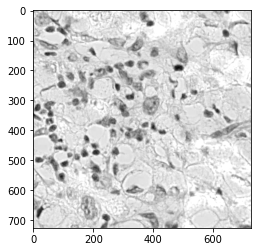

In [10]:
import numpy as np
from matplotlib.pyplot import imshow, subplot, plot
from  skimage import filters, morphology, io, img_as_uint, measure
import scipy.ndimage as snd
img_path = canalH_paths[0]
image = io.imread(base_path_H+img_path)
imshow(image, cmap='gray')

## Umbral de otsu

In [11]:
#from curso de mi profe guia, es la idea equivalente a otsu
from skimage import data, filters, measure, morphology

image = io.imread('/content/gdrive/MyDrive/memoria/jueves22/canalH/ejemplo_x40_z0_a0_clase_3+.png-H.tif')

threshold = filters.threshold_otsu(image)#otsu tiene que entrar un grey scale
print('threshold=',threshold)

binary=image<threshold#esto es lo de la indexacion

#imshow(binary, cmap='gray')
all_labels = measure.label(binary, background=0)

properties = measure.regionprops(all_labels)#<--- esto equivale a coneccted components, viene de skimage


threshold= 195


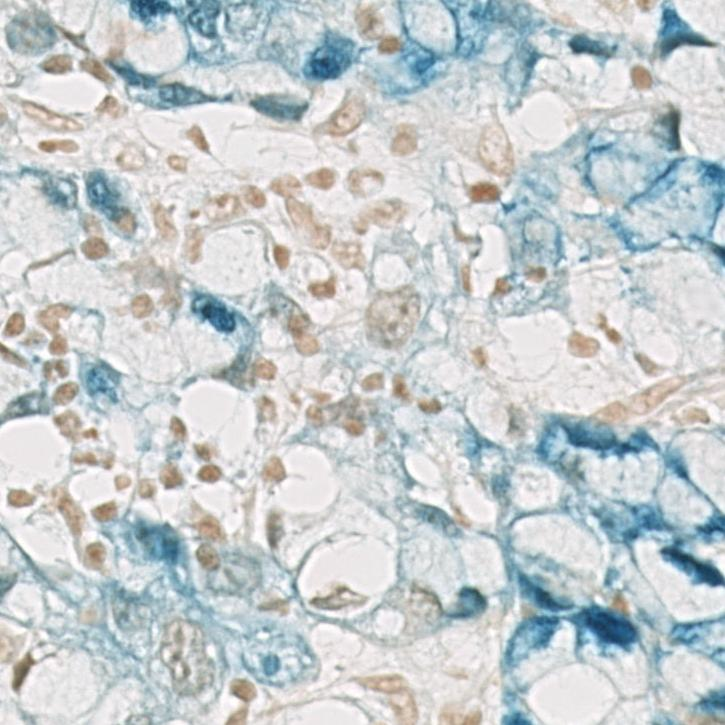

In [12]:
image = io.imread('/content/gdrive/MyDrive/memoria/jueves22/png_imgs/ejemplo_x40_z0_a0_clase_3+.png')
from google.colab.patches import cv2_imshow
cv2_imshow(image)

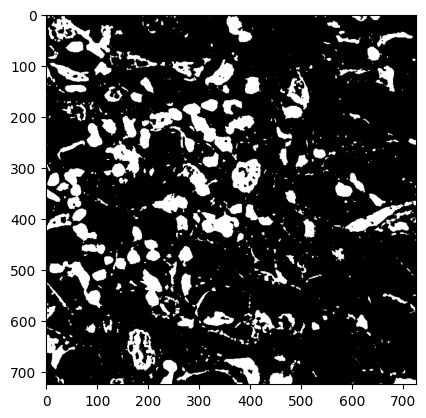

In [13]:
plt.style.use('default')
imshow(binary, cmap='gray')

### Filtro las celulas muy peueñas

In [14]:
#type(properties[0])
#properties es una lista de objetos:'RegionProperties', cada uno es una celula, tiene los atributos de la celula

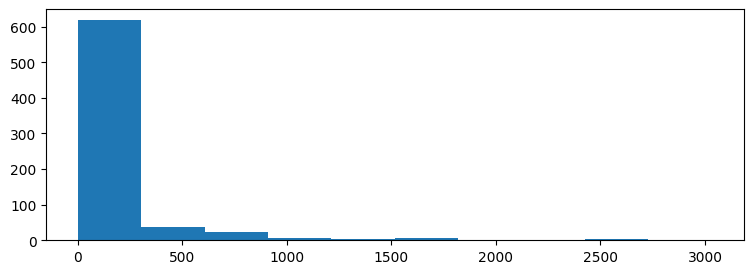

In [15]:
properties_areas=[]
[properties_areas.append(propertie.area) for propertie in properties]
#'''
plt.figure(figsize=(9, 3))
plt.hist(properties_areas)
plt.show() #dibujamos el histograma
#'''
#print(properties_areas)

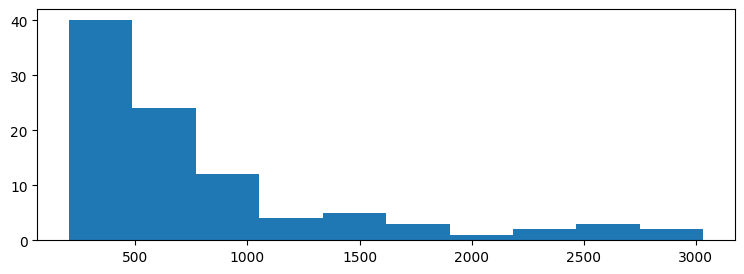

In [16]:
umbral_area = 200
properties_areas=[]
[properties_areas.append(propertie.area) for propertie in properties if propertie.area>umbral_area]
#'''
plt.figure(figsize=(9, 3))#<--- forma mas clara de hacer graficos
plt.hist(properties_areas)
plt.show() #dibujamos el histograma
#'''
#print(properties_areas)

conclusion: 200 es un buen umbral para el area de las propeties

In [17]:
#encontrar los paths de las imagenes H y DAB
base_path_H = "/content/gdrive/MyDrive/memoria/jueves22/canalH/"
base_path_DAB = "/content/gdrive/MyDrive/memoria/jueves22/canalDAB/"

canalH_paths=[]
canalDAB_paths=[]
[canalH_paths.append(img_path) for img_path in os.listdir(base_path_H)]
[canalDAB_paths.append(img_path) for img_path in os.listdir(base_path_DAB)]

canalH_paths = sort_especial(canalH_paths)#despues aplicar lo de hacerlo en forma de funcion que modifique el orden de la lista
canalDAB_paths = sort_especial(canalDAB_paths)
print(canalH_paths)
print(canalDAB_paths)

['ejemplo_x40_z0_a0_clase_3+.png-H.tif', 'ejemplo_x40_z0_a1_clase_2+.png-H.tif', 'ejemplo_x40_z0_a2_clase_0.png-H.tif', 'ejemplo_x40_z0_a3_clase_3+.png-H.tif', 'ejemplo_x40_z0_a4_clase_0.png-H.tif', 'ejemplo_x40_z0_a5_clase_0.png-H.tif', 'ejemplo_x40_z0_a6_clase_no-tumor.png-H.tif', 'ejemplo_x40_z0_a7_clase_no-tumor.png-H.tif', 'ejemplo_x40_z0_a8_clase_no-tumor.png-H.tif', 'ejemplo_x40_z0_a9_clase_0.png-H.tif', 'ejemplo_x40_z0_a10_clase_2+.png-H.tif', 'ejemplo_x40_z0_a11_clase_2+.png-H.tif', 'ejemplo_x40_z0_a12_clase_2+.png-H.tif', 'ejemplo_x40_z0_a13_clase_1+.png-H.tif', 'ejemplo_x40_z0_a14_clase_2+.png-H.tif']
['ejemplo_x40_z0_a0_clase_3+.png-DAB.tif', 'ejemplo_x40_z0_a1_clase_2+.png-DAB.tif', 'ejemplo_x40_z0_a2_clase_0.png-DAB.tif', 'ejemplo_x40_z0_a3_clase_3+.png-DAB.tif', 'ejemplo_x40_z0_a4_clase_0.png-DAB.tif', 'ejemplo_x40_z0_a5_clase_0.png-DAB.tif', 'ejemplo_x40_z0_a6_clase_no-tumor.png-DAB.tif', 'ejemplo_x40_z0_a7_clase_no-tumor.png-DAB.tif', 'ejemplo_x40_z0_a8_clase_no-tumor.

In [18]:
image_H = io.imread(base_path_H+canalH_paths[0])
H_gray = rgb2gray(image_H)
threshold = filters.threshold_otsu(image_H)#tiene que entrar un gray scale a otsu
img_binary = image_H<threshold
    
all_labels = measure.label(img_binary, background=0)
properties = [propertie for propertie in measure.regionprops(all_labels) if propertie.area > 200 ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  


In [19]:
def propertie_cords2mask(lado_parche,propertie_cords):
    mask = np.zeros( shape = (lado_parche, lado_parche),dtype=int )
    for coord in propertie_cords:
        mask[coord[0],coord[1]] += 255
    return mask


In [44]:
def juntar_paths_H_y_DAB(canalH_paths,canalDAB_paths):
    paths_HDAB=[]
    for i in range(len(canalH_paths)):
        aux=[]
        aux.append(canalH_paths[i])
        aux.append(canalDAB_paths[i])
        paths_HDAB.append(aux)
    return paths_HDAB


#######################arreglar esto mapana el np.zeros debeveria crear una maskara boooleana de false y luego ir rellenandola. por eso daba todo negro a la salida
def or_masks(boolean_mask1, boolean_mask2):
    if boolean_mask1.shape != boolean_mask2.shape:
        raise Exception('boolean_mask1 y boolean_mask2 deben tener la misma dimension')
    boolean_mask_result = np.zeros_like(mask1)
    for i in range(mask1.shape[1]):
        for j in range(mask1.shape[0]):
            if mask1[i,j]==True or mask1[i,j]==True:
                mask_result[i,j]=True
    return mask_result 

In [45]:
base_path_H = "/content/gdrive/MyDrive/memoria/jueves22/canalH/"
base_path_DAB = "/content/gdrive/MyDrive/memoria/jueves22/canalDAB/"
paths_HDAB = juntar_paths_H_y_DAB(canalH_paths,canalDAB_paths)
HDAB=[]
H_features=[]
lista_properties=[]

path_H = paths_HDAB[0][0]
path_DAB = paths_HDAB[0][1]

image_H = io.imread(base_path_H+path_H)
threshold_H = filters.threshold_otsu(image_H)#tiene que entrar un gray scale a otsu
img_H_binary = image_H<threshold_H

image_DAB = io.imread(base_path_DAB+path_DAB)
threshold_DAB = filters.threshold_otsu(image_DAB)#tiene que entrar un gray scale a otsu
img_DAB_binary = image_DAB<threshold_DAB


img_binary_merged = or_masks(img_H_binary, img_DAB_binary)

all_labels = measure.label(img_binary_merged, background=0)
properties_previo = measure.regionprops(all_labels)
properties=[]
[properties.append(propertie) for propertie in properties_previo if propertie.area > 200 ]


NameError: ignored

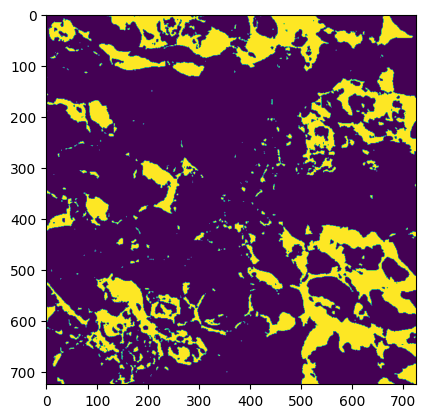

In [43]:
imshow(img_DAB_binary)

##feature extracion canales H y DAB

In [27]:
from skimage.color import rgb2gray
from skimage import data, filters, measure, morphology, io
base_path_H = "/content/gdrive/MyDrive/memoria/jueves22/canalH/"
base_path_DAB = "/content/gdrive/MyDrive/memoria/jueves22/canalDAB/"
paths_HDAB = juntar_paths_H_y_DAB(canalH_paths,canalDAB_paths)
HDAB=[]
H_features=[]
lista_properties=[]

for path_HDAB in paths_HDAB:#las imagenes de la carpeta canal_H ya estan en gray scale
    path_H = path_HDAB[0]
    path_DAB = path_HDAB[1]
    
    image_H = io.imread(base_path_H+path_H)
    threshold_H = filters.threshold_otsu(image_H)#tiene que entrar un gray scale a otsu
    img_H_binary = image_H<threshold_H

    image_DAB = io.imread(base_path_DAB+path_DAB)
    threshold_DAB = filters.threshold_otsu(image_DAB)#tiene que entrar un gray scale a otsu
    img_DAB_binary = image_DAB<threshold_DAB
    

    img_binary_merged = or_masks(img_H_binary, img_DAB_binary)
    
    all_labels = measure.label(img_binary_merged, background=0)
    properties_previo = measure.regionprops(all_labels)
    properties=[]
    [properties.append(propertie) for propertie in properties_previo if propertie.area > 200 ]
    
    lista_properties.append(properties)
    H_anotation=[]
    for celula_propertie in properties:
            radio_condicion = 10
            #skimage guardas imagenes en y,x es decir el shape[0] da la medicion de y, y el shape[1] da la de x
            y_centroid = int(celula_propertie.centroid[0])
            x_centroid = int(celula_propertie.centroid[1])
            #print('y_centroid=',y_centroid,type(y_centroid))
            #print('x_centroid=',x_centroid, type(x_centroid))
            for coord in celula_propertie.coords:
                y_coord = coord[0]
                x_coord = coord[1]
                a = (y_centroid-y_coord)**2+(x_centroid-x_coord)**2
                #print('a=',a)
                # print('radio_condicion**2=',radio_condicion**2)
                if a < radio_condicion**2:#si la coordenada esta dentro del radio
                    #if coord[0]>image.shape[0] or coord[0]>image.shape[0]:
                    #    print('salio una coordenada fuera de los limites de la imagen')
                    H_anotation.append(H_gray[coord[1],coord[0]])
            '''
            for coord in celula_propertie.coords: # este for es el que tiene que sacar los featuers solo de  los pixeles en con valor 1
                if coord[0]>image.shape[0] or coord[0]>image.shape[0]:
                    print('salio una coordenada muy grande')
                H_anotation.append(H_gray[coord[0],coord[1]])
            '''
    H_features.append(H_anotation)        
HDAB.append(H_features)    
#print('thresholds_otsu=',thresholds_otsu)
print('----------------------------------------')
print('len(propertie[0])=',len(lista_properties[0]))
#############################################################
#'''
DAB_features=[]
i=0
for img_path in canalDAB_paths:
    image = io.imread(base_path_DAB+img_path)
    #print(image.shape)
    DAB_gray = rgb2gray(image)
    DAB_anotation=[]
    for celula_propertie in lista_properties[i]:
        radio_condicion = 10
        #skimage guardas imagenes en y,x es decir el shape[0] da la medicion de y, y el shape[1] da la de x
        y_centroid = int(celula_propertie.centroid[0])
        x_centroid = int(celula_propertie.centroid[1])
        #print('y_centroid=',y_centroid,type(y_centroid))
        #print('x_centroid=',x_centroid, type(x_centroid))    
        for coord in celula_propertie.coords: # este for es el que tiene que sacar los featuers solo de  los pixeles en con valor 1
            y_coord = coord[0]
            x_coord = coord[1]
            a = (y_centroid-y_coord)**2+(x_centroid-x_coord)**2
            if a < radio_condicion**2:#si la coordenada esta dentro del radio
                if coord[0]>image.shape[0] or coord[0]>image.shape[0]:
                    print('salio una coordenada muy grande')
                DAB_anotation.append(DAB_gray[coord[1],coord[0]])#hay un problema con el prpeti queestoy usando
    i+=1
    DAB_features.append(DAB_anotation)        
#############################################################
#agregando tercera componenete con colores
HDAB.append(DAB_features)    

clases_roi=[]
[clases_roi.append(img_path.split('_')[5].split('.')[0]) for img_path in canalH_paths]
colores_roi = transformacion_clase2color(clases_roi)
HDAB.append(colores_roi)   
HDAB.append(clases_roi) 
#'''


----------------------------------------
len(propertie[0])= 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


In [26]:
print(len(HDAB[0][4]))
print(len(HDAB[1][4]))


0
0


## Scatter plot

In [ ]:
plt.rcParams['axes.labelsize']=60
plt.rcParams['xtick.labelsize']=50    #tamaño de los numeros del eje X
plt.rcParams['ytick.labelsize']=50    #tamaño de los numeros del eje Y
plt.rcParams['xtick.color']='magenta'        #color numenos eje X
plt.rcParams['ytick.color']='magenta'      #color numenos eje Y
plt.rcParams['axes.labelcolor']='magenta'  #color de los nombres de los ejes
plt.rcParams['axes.grid']=True            #por defecto, printear la grilla

Graficos tienen una linea en 190 porque se binariza con la mascara del canal H y el umbral es en torno als 200

In [ ]:
#vizualizacion

import pandas as pd
import matplotlib.pyplot as plt       

plt.clf()
fig, ax = plt.subplots(figsize=(40,40))
ax.set(xlim=(0, 255), ylim=(0, 255))

try:#cada ax.scatter plotea los pixeles de una anotacion
    plt.text(10, 150, 'clase 3+ en magenta',fontsize=40)
    ax.scatter(HDAB[0][0] , HDAB[1][0], color= HDAB[2][0] )#clase: 3+ MAGENTA
    ax.scatter(HDAB[0][3] , HDAB[1][3], color= HDAB[2][3] )#clase: 3+ MAGENTA
    
    #plt.text(10, 150, 'clase 2+ en azul',fontsize=40)
    #ax.scatter(HDAB[0][1] , HDAB[1][1], color= HDAB[2][1] )#clase: 2+ AZUL
    #ax.scatter(HDAB[0][10] , HDAB[1][10], color= HDAB[2][10] )#clase: 2+ AZUL
    #ax.scatter(HDAB[0][11] , HDAB[1][11], color= HDAB[2][11] )#clase: 2+ AZUL
    #ax.scatter(HDAB[0][12] , HDAB[1][12], color= HDAB[2][12] )#clase: 2+ AZUL
    #ax.scatter(HDAB[0][14] , HDAB[1][14], color= HDAB[2][14] )#clase: 2+ AZUL

    #plt.text(10, 150, 'clase 1+ en rojo',fontsize=40) 
    #ax.scatter(HDAB[0][13] , HDAB[1][13], color= HDAB[2][13] )#clase: 1+ ROJO
    
    #plt.text(10, 150, 'clase 0+ en amarillo',fontsize=40) 
    #ax.scatter(HDAB[0][2] , HDAB[1][2], color= HDAB[2][2] )#clase: 0 VERDE (O AMARILLO)
    #ax.scatter(HDAB[0][4] , HDAB[1][4], color= HDAB[2][4] )#clase: 0 VERDE (O AMARILLO)
    #ax.scatter(HDAB[0][5] , HDAB[1][5], color= HDAB[2][5] )#clase: 0 VERDE (O AMARILLO)
    #ax.scatter(HDAB[0][9] , HDAB[1][9], color= HDAB[2][9] )#clase: 0 VERDE (O AMARILLO)
    
    #plt.text(10, 150, 'clase no_tumor en negro',fontsize=40) 
    #ax.scatter(HDAB[0][6] , HDAB[1][6], color= HDAB[2][6] )#clase: no_tumor NEGRO 
    #ax.scatter(HDAB[0][7] , HDAB[1][7], color= HDAB[2][7] )#clase: no_tumor NEGRO
    #ax.scatter(HDAB[0][8] , HDAB[1][8], color= HDAB[2][8] )#clase: no_tumor NEGRO
    

except:
    pass
#legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="clases")
#ax.add_artist(legend1)

ax.set_xlabel('Hematoxilina H (0-255)')
ax.set_ylabel('DAB Diaminobencidina (0-255)')
plt.show()




## construyendo el Kmeans

### calculando los centroides

In [ ]:
    def get_indexacion(lista_clases, clase):#la clase debe entrar como string
        indices_aparicion = []
        n_apariciones = lista_clases.count(clase)
        c = 0
        partida_busqueda=0
        while c < n_apariciones:
            indice = lista_clases.index(clase,partida_busqueda)
            partida_busqueda=indice+1
            indices_aparicion.append(indice)
            c+=1
        return indices_aparicion


In [ ]:
print(HDAB[3])

In [ ]:
#calculando los centroides de las clases
import numpy as np
centroides=[]#largo 5 porque son 5 clases

indexacion_clase_anotacion=[]
[indexacion_clase_anotacion.append(img_path.split('_')[5].split('.')[0]) for img_path in canalH_paths]

indices_clase_no_tumor = get_indexacion(indexacion_clase_anotacion,'no-tumor')
indices_clase_0 = get_indexacion(indexacion_clase_anotacion,'0')
indices_clase_1 = get_indexacion(indexacion_clase_anotacion,'1+')
indices_clase_2 = get_indexacion(indexacion_clase_anotacion,'2+')
indices_clase_3 = get_indexacion(indexacion_clase_anotacion,'3+')

#colors = HDAB.pop(2)#elminar la ultima lista que tiene los colores de las clases

H_feat=HDAB[0]
DAB_feat=HDAB[1]
mean_H_feat=[]
mean_DAB_feat=[]
[mean_H_feat.append(sum(l)/len(l)) for l in H_feat]
[mean_DAB_feat.append(sum(l)/len(l)) for l in DAB_feat]


#'''
H_means_clase_no_tumor=[mean_H_feat[i] for i in indices_clase_no_tumor]#las listas son mutables
#www.freecodecamp.org/espanol/news/explicacion-de-las-listas-de-python-comprension-de-len-pop-index-y-list-comprehension
H_means_clase_0=[mean_H_feat[i] for i in indices_clase_0]
H_means_clase_1=[mean_H_feat[i] for i in indices_clase_1]
H_means_clase_2=[mean_H_feat[i] for i in indices_clase_2]
H_means_clase_3=[mean_H_feat[i] for i in indices_clase_3]

DAB_means_clase_no_tumor=[mean_DAB_feat[i] for i in indices_clase_no_tumor]#las listas son mutables
DAB_means_clase_0=[mean_DAB_feat[i] for i in indices_clase_0]
DAB_means_clase_1=[mean_DAB_feat[i] for i in indices_clase_1]
DAB_means_clase_2=[mean_DAB_feat[i] for i in indices_clase_2]
DAB_means_clase_3=[mean_DAB_feat[i] for i in indices_clase_3]

H_mean_clase_no_tumor = int(sum(H_means_clase_no_tumor)/len(H_means_clase_no_tumor))
H_mean_clase_0 = int(sum(H_means_clase_0)/len(H_means_clase_0))
H_mean_clase_1 = int(sum(H_means_clase_1)/len(H_means_clase_1))
H_mean_clase_2 = int(sum(H_means_clase_2)/len(H_means_clase_2))
H_mean_clase_3 = int(sum(H_means_clase_3)/len(H_means_clase_3))

DAB_mean_clase_no_tumor = int(sum(DAB_means_clase_no_tumor)/len(DAB_means_clase_no_tumor))
DAB_mean_clase_0 = int(sum(DAB_means_clase_0)/len(DAB_means_clase_0))
DAB_mean_clase_1 = int(sum(DAB_means_clase_1)/len(DAB_means_clase_1))
DAB_mean_clase_2 = int(sum(DAB_means_clase_2)/len(DAB_means_clase_2))
DAB_mean_clase_3 = int(sum(DAB_means_clase_3)/len(DAB_means_clase_3))

centroide_clase_no_tumor=[H_mean_clase_no_tumor,DAB_mean_clase_no_tumor]
centroide_clase_0=[H_mean_clase_0,DAB_mean_clase_0]
centroide_clase_1=[H_mean_clase_1,DAB_mean_clase_1]
centroide_clase_2=[H_mean_clase_2,DAB_mean_clase_2]
centroide_clase_3=[H_mean_clase_3,DAB_mean_clase_3]

centroides.append(centroide_clase_no_tumor)
centroides.append(centroide_clase_0)
centroides.append(centroide_clase_1)
centroides.append(centroide_clase_2)
centroides.append(centroide_clase_3)
print(centroides)


In [ ]:
#vizualizacion

import pandas as pd
import matplotlib.pyplot as plt       

plt.clf()
fig, ax = plt.subplots(figsize=(40,40))
ax.set(xlim=(0, 255), ylim=(0, 255))

try:#cada ax.scatter plotea los pixeles de una anotacion
    plt.text(10, 150, 'clase 3+ en magenta',fontsize=40, color='m')
    #ax.scatter(HDAB[0][0] , HDAB[1][0], color= HDAB[2][0] )#clase: 3+ MAGENTA
    #ax.scatter(HDAB[0][3] , HDAB[1][3], color= HDAB[2][3] )#clase: 3+ MAGENTA
    plt.scatter(centroide_clase_3[0], centroide_clase_3[1], s=1000, marker='^', c='m')


    plt.text(10, 140, 'clase 2+ en azul',fontsize=40, color='b')
    #ax.scatter(HDAB[0][1] , HDAB[1][1], color= HDAB[2][1] )#clase: 2+ AZUL
    #ax.scatter(HDAB[0][10] , HDAB[1][10], color= HDAB[2][10] )#clase: 2+ AZUL
    #ax.scatter(HDAB[0][11] , HDAB[1][11], color= HDAB[2][11] )#clase: 2+ AZUL
    #ax.scatter(HDAB[0][12] , HDAB[1][12], color= HDAB[2][12] )#clase: 2+ AZUL
    #ax.scatter(HDAB[0][14] , HDAB[1][14], color= HDAB[2][14] )#clase: 2+ AZUL
    plt.scatter(centroide_clase_2[0], centroide_clase_2[1], s=1000, marker='^', c='b')

    plt.text(10, 130, 'clase 1+ en rojo',fontsize=40, color='r') 
    #ax.scatter(HDAB[0][13] , HDAB[1][13], color= HDAB[2][13] )#clase: 1+ ROJO
    plt.scatter(centroide_clase_1[0], centroide_clase_1[1], s=1000, marker='^', c='r')

    plt.text(10, 120, 'clase 0+ en amarillo',fontsize=40, color='y') 
    #ax.scatter(HDAB[0][2] , HDAB[1][2], color= HDAB[2][2] )#clase: 0 amarillo (o verde)
    #ax.scatter(HDAB[0][4] , HDAB[1][4], color= HDAB[2][4] )#clase: 0 amarillo (o verde)
    #ax.scatter(HDAB[0][5] , HDAB[1][5], color= HDAB[2][5] )#clase: 0 amarillo (o verde)
    #ax.scatter(HDAB[0][9] , HDAB[1][9], color= HDAB[2][9] )#clase: 0 amarillo (o verde)
    plt.scatter(centroide_clase_0[0], centroide_clase_0[1], s=1000, marker='^', c='y')

    plt.text(10, 110, 'clase no_tumor en negro',fontsize=40, color='k') 
    #ax.scatter(HDAB[0][6] , HDAB[1][6], color= HDAB[2][6] )#clase: no_tumor NEGRO 
    #ax.scatter(HDAB[0][7] , HDAB[1][7], color= HDAB[2][7] )#clase: no_tumor NEGRO
    #ax.scatter(HDAB[0][8] , HDAB[1][8], color= HDAB[2][8] )#clase: no_tumor NEGRO
    plt.scatter(centroide_clase_no_tumor[0], centroide_clase_no_tumor[1], s=1000, marker='^', c='k')
except:
    pass
#legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="clases")
#ax.add_artist(legend1)

ax.set_xlabel('Hematoxilina H (0-255)')
ax.set_ylabel('DAB Diaminobencidina (0-255)')
plt.show()

###Clasificando los pixeles de las roi

In [ ]:
from math import sqrt
def clasificar_muestra(centroides,muestra_HDAB):
    clase=['0','1+','2+','3+','no-tumor']
    d_mustraHDAB_centroides=[]
    for centroide in centroides:
        d = math.sqrt((centroide[0]-muestra_HDAB[0])**2+(centroide[1]-muestra_HDAB[1])**2)
        d_mustraHDAB_centroides.append(d)
    index_min = d_mustraHDAB_centroides.index(min(d_mustraHDAB_centroides))
    prediccion_clase = clase[index_min]
    print('prediccion_clase para muestra = ', prediccion_clase)
    print('con distancia:',min(d_mustraHDAB_centroides))
    print('-----------------------------------------------------')
    return prediccion_clase

def clase2intnumber_encoding(clase):
    mapeo_clase2numero = {'0':int(0),
                          '1+':int(1), 
                          '2+':int(2),
                          '3+':int(3),               
                          'no-tumor':int(4)
                        } 
    intnumber = mapeo_clase2numero[clase]
    return intnumber    

def intnumber2rgbcolor_encoding(intnumber):#al final esta no se va a usar
    mapeo_intnumber2rgbcolor = {int(0): (255, 0, 255),#clase 0
                                int(1): (0, 0, 255),#clase 1
                                int(2): (255, 0, 0),#clase 2
                                int(3): (255, 255, 0),#clase 3         
                                int(4): (0, 0, 0)#clase no-tumor
                                } 
    rgbcolor = mapeo_intnumber2rgbcolor[intnumber]
    return rgbcolor    

def clase2rgbcolor_encoding(clase):
    mapeo_clase2rgbcolor = {'0': (255, 0, 255),#clase 0 verde
                            '1+': (0, 0, 255),#clase 1 rojo
                            '2+': (255, 0, 0),#clase 2 azul
                            '3+': (255, 255, 0),#clase 3 magenta        
                            'no-tumor': (0, 0, 0)#clase no-tumor
                            } 
    rgbcolor_tuple = mapeo_clase2rgbcolor[clase]
    return rgbcolor_tuple


In [ ]:
def juntar_paths_H_y_DAB(canalH_paths,canalDAB_paths):
    paths_HDAB=[]
    for i in range(len(canalH_paths)):
        aux=[]
        aux.append(canalH_paths[i])
        aux.append(canalDAB_paths[i])
        paths_HDAB.append(aux)
    return paths_HDAB

paths_HDAB = juntar_paths_H_y_DAB(canalH_paths,canalDAB_paths)

\#Predecir
entra HDAB y path y sale una lista con maskaras, una por cada anitacion, cada pixel de ellas tiene valores de 0 (clase no-tumor) a 5 (clase 3+)

In [ ]:
from skimage.color import rgb2gray
from skimage import data, filters, measure, morphology

lista_predicted_img_mask=[]
lista_predicted_img_mask_class=[]
for paths in paths_HDAB:

    image_H = io.imread(base_path_H+paths[0])
    H_gray = rgb2gray(image_H)

    #creamos una mascara de zeros con la misma dimension que la imagen
    #predicted_img_mask = np.zeros_like(image_H)
    mask_shape = (image_H.shape[0],image_H.shape[1],3)
    predicted_img_mask = np.full(shape = mask_shape, fill_value=0, dtype=np.int)
    predicted_img_mask_class= np.full(shape = (image_H.shape[0],image_H.shape[1]), fill_value=0, dtype=np.int)

    image_DAB = io.imread(base_path_DAB+paths[1])
    DAB_gray = rgb2gray(image_DAB)
    
    threshold = filters.threshold_otsu(image_H)
    img_binary = image_H<threshold
    all_labels = measure.label(img_binary, background=0)
    properties_previo = measure.regionprops(all_labels)
    properties=[]
    [properties.append(propertie) for propertie in properties_previo if propertie.area > 200 ]
    
    #lista_properties.append(properties)

    for celula_propertie in properties:
            for coord in celula_propertie.coords:
                muestra_HDAB = ( H_gray[coord[0],coord[1]] , DAB_gray[coord[0],coord[1]] )
                prediccion_clase = clasificar_muestra(centroides,muestra_HDAB)#prediccion_clase es un str puede ser 'no-tumor','0+','1+','2+' o '3+']
                #en caso de error revizar opencv leen en bgr y no en rgb
                predicted_img_mask[coord[0],coord[1],2] = clase2rgbcolor_encoding(prediccion_clase)[0]
                predicted_img_mask[coord[0],coord[1],1] = clase2rgbcolor_encoding(prediccion_clase)[1]
                predicted_img_mask[coord[0],coord[1],0] = clase2rgbcolor_encoding(prediccion_clase)[2]
                
                predicted_img_mask_class[coord[0],coord[1]] = clase2intnumber_encoding(prediccion_clase)
    lista_predicted_img_mask.append(predicted_img_mask)
    lista_predicted_img_mask_class.append(predicted_img_mask_class)
    break



In [ ]:
#obtener los paths de las imagenes rgb para despues plotearlas al lado de las maskaras
base_path_rgb = '/content/gdrive/MyDrive/memoria/jueves22/png_imgs/'
rgb_img_paths=sort_especial( [img_path for img_path in os.listdir(base_path_rgb)] )
print(rgb_img_paths)

In [ ]:
plt.style.use('default')
#imshow(lista_predicted_img_mask[1], cmap='gray')
indice_mask= 1
imshow(lista_predicted_img_mask[indice_mask])
plt.title('clase : '+ HDAB[3][indice_mask])
plt.text(1150, 100, 'clase 3+ -> magenta',fontsize=15) 
plt.text(1150, 200, 'clase 2+ -> azul',fontsize=15) 
plt.text(1150, 300, 'clase 1+ -> rojo',fontsize=15) 
plt.text(1150, 400, 'clase 0 -> amarillo/verde',fontsize=15) 
plt.text(1150, 500, 'clase no-tumor-> negro',fontsize=15)
#plt.colorbar()



In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('anotacion 1, clase : '+ str(HDAB[3][1]))
ax1.imshow(lista_predicted_img_mask[1])
#ax1.colorbar()
rgb_image = io.imread(base_path_rgb+rgb_img_paths[1])
ax2.imshow(rgb_image)

In [ ]:
HDAB[3][0]

In [ ]:

img_path = '/content/gdrive/MyDrive/memoria/jueves22/png_imgs/ejemplo_x40_z0_a0_clase_3+.png'

rgb_image = io.imread(base_path_rgb+rgb_img_paths[1])

imshow(rgb_image)

##Clasificación por clase mayoritaria en celula

In [ ]:
from skimage.color import rgb2gray
from skimage import data, filters, measure, morphology, io
import pandas as pd
lista_predicted_img_mask=[]
lista_predicted_img_mask_class=[]
for paths in paths_HDAB:

    image_H = io.imread(base_path_H+paths[0])
    H_gray = rgb2gray(image_H)
    #creamos una mascara de zeros con la misma dimension que la imagen
    #predicted_img_mask = np.zeros_like(image_H)
    mask_shape = (image_H.shape[0],image_H.shape[1],3)
    predicted_img_mask = np.full(shape = mask_shape, fill_value=0, dtype=np.int)
    predicted_img_mask_class= np.full(shape = (image_H.shape[0],image_H.shape[1]), fill_value=0, dtype=np.int)

    image_DAB = io.imread(base_path_DAB+paths[1])#paths[1] son los paths de las imgenes DAB
    DAB_gray = rgb2gray(image_DAB)
    
    threshold = filters.threshold_otsu(image_H)
    img_binary = image_H<threshold
    all_labels = measure.label(img_binary, background=0)
    '''
    umbral_area = 200
    properties_areas=[propertie.area for propertie in properties if propertie.area>umbral_area]
    plt.figure(figsize=(9, 3))
    plt.hist(properties_areas)
    plt.show() #dibujamos el histograma
    '''
    properties_previo = measure.regionprops(all_labels)
    properties=[]
    [properties.append(propertie) for propertie in properties_previo if propertie.area > 200 ]
    #lista_properties.append(properties)
    for celula_propertie in properties:
            #creamos un objeto Series de pandas, como indice tiene los nombres de las clases y como info puros ceros que representan los votos
            votos_clases_en_celula = pd.Series([0, 0, 0, 0, 0], index = ['no-tumor', '0', '1+', '2+','3+'])
            for coord in celula_propertie.coords:
                muestra_HDAB = ( H_gray[coord[0],coord[1]] , DAB_gray[coord[0],coord[1]] )
                prediccion_clase = clasificar_muestra(centroides,muestra_HDAB)#prediccion_clase es un str puede ser 'no-tumor','0+','1+','2+' o '3+']
                #en caso de error revizar opencv leen en bgr y no en rgb
                votos_clases_en_celula[prediccion_clase] +=1#esto suma 1 voto a la clase correspondiente
            clase_mas_votos_celula = votos_clases_en_celula.idxmax()#idxmax es una funcion de pandas retorna el indice de entre los valores(informacion) que tenda mayor valor    
            
            for coord in celula_propertie.coords:#pintar toda la celula del mismo color de la clase mayoritaria
                predicted_img_mask[coord[0],coord[1],2] = clase2rgbcolor_encoding(clase_mas_votos_celula)[0]
                predicted_img_mask[coord[0],coord[1],1] = clase2rgbcolor_encoding(clase_mas_votos_celula)[1]
                predicted_img_mask[coord[0],coord[1],0] = clase2rgbcolor_encoding(clase_mas_votos_celula)[2]
                predicted_img_mask_class[coord[0],coord[1]] = clase2intnumber_encoding(clase_mas_votos_celula)

    lista_predicted_img_mask.append(predicted_img_mask)
    lista_predicted_img_mask_class.append(predicted_img_mask_class)
    break



In [ ]:
lado[print(a.shape) for a in lista_predicted_img_mask]

In [ ]:

plt.style.use('default')
#imshow(lista_predicted_img_mask[1], cmap='gray')
indice_mask= 1
lado_img = lista_predicted_img_mask[indice_mask].shape[0]
pos_texto = lado_img+50
imshow(lista_predicted_img_mask[indice_mask])
plt.title('clase : '+ HDAB[3][indice_mask])
plt.text(pos_texto, 100, 'clase 3+ -> magenta',fontsize=15) 
plt.text(pos_texto, 200, 'clase 2+ -> azul',fontsize=15) 
plt.text(pos_texto, 300, 'clase 1+ -> rojo',fontsize=15) 
plt.text(pos_texto, 400, 'clase 0 -> amarillo/verde',fontsize=15) 
plt.text(pos_texto, 500, 'clase no-tumor-> negro',fontsize=15)
#plt.colorbar()

In [ ]:
indice_mask= 0
fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.suptitle('anotacion '+str(indice_mask)+', clase : '+ str(HDAB[3][indice_mask]))
ax1.imshow(lista_predicted_img_mask[indice_mask])
#ax1.colorbar()
rgb_image = io.imread(base_path_rgb+rgb_img_paths[indice_mask])
ax2.imshow(rgb_image)

lado_img = lista_predicted_img_mask[indice_mask].shape[0]
pos_texto = lado_img+50
plt.title('anotacion '+str(indice_mask)+', clase : '+ str(HDAB[3][indice_mask]))

plt.text(pos_texto, 100, 'clase 3+ -> magenta',fontsize=15, c='m') 
plt.text(pos_texto, 200, 'clase 2+ -> azul',fontsize=15, c='b') 
plt.text(pos_texto, 300, 'clase 1+ -> rojo',fontsize=15, c='r') 
plt.text(pos_texto, 400, 'clase 0 -> amarillo/verde',fontsize=15, c='y') 
plt.text(pos_texto, 500, 'clase no-tumor-> negro',fontsize=15, c='k')

plt.savefig('/content/gdrive/MyDrive/memoria/jueves22/resultados_plots/a'+str(indice_mask)+'.png')



In [ ]:
#guardar los plots  generadas
for indice_mask in range(15):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    #fig.suptitle('anotacion '+str(indice_mask)+', clase : '+ str(HDAB[3][indice_mask]))
    ax1.imshow(lista_predicted_img_mask[indice_mask])
    #ax1.colorbar()
    rgb_image = io.imread(base_path_rgb+rgb_img_paths[indice_mask])
    ax2.imshow(rgb_image)

    lado_img = lista_predicted_img_mask[indice_mask].shape[0]
    pos_texto = lado_img+50
    plt.title('anotacion '+str(indice_mask)+', clase patologo: '+ str(HDAB[3][indice_mask]))

    plt.text(pos_texto, 100, 'clase 3+ -> magenta',fontsize=15, c='m') 
    plt.text(pos_texto, 200, 'clase 2+ -> azul',fontsize=15, c='b') 
    plt.text(pos_texto, 300, 'clase 1+ -> rojo',fontsize=15, c='r') 
    plt.text(pos_texto, 400, 'clase 0 -> amarillo/verde',fontsize=15, c='y') 
    plt.text(pos_texto, 500, 'clase no-tumor-> negro',fontsize=15, c='k')

    plt.savefig('/content/gdrive/MyDrive/memoria/jueves22/resultados_plots/a'+str(indice_mask)+'.png')


In [ ]:
#guardar las maskaras generadas
proy_folder = '/content/gdrive/MyDrive/memoria/jueves22/'
try:
    os.mkdir(proy_folder+'mask_predicted')
except:     
    pass
path_folder_predicted_mask = '/content/gdrive/MyDrive/memoria/jueves22/mask_predicted/'
i=0
for mask in lista_predicted_img_mask:
    cv2.imwrite(path_folder_predicted_mask+'mask_predicted_a_'+str(i)+'.tif', mask)
    i+=1


#Metricas

##Matriz de confusion

In [ ]:
predicted_img_mask_class[1][1]

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

lista_confusion_matrix=[]
lista_accuracy=[]
i=0
for mask_pred in lista_predicted_img_mask_class:
    mask_pred = mask_pred.flatten()
    mask_true = np.full(shape = mask_pred.shape, fill_value = clase2intnumber_encoding(HDAB[3][i]), dtype=np.int)
    lista_confusion_matrix.append(confusion_matrix(mask_true, mask_pred))
    lista_accuracy.append(accuracy_score(mask_true, mask_pred))

In [ ]:
print(lista_accuracy)#f

#Maskara rojo/verde

In [ ]:
for mask_pred in lista_predicted_img_mask_class:
    mask_pred = mask_pred.flatten()
    mask_true = np.full(shape = mask_pred.shape, fill_value = clase2intnumber_encoding(HDAB[3][i]), dtype=np.int)
    lista_confusion_matrix.append(confusion_matrix(mask_true, mask_pred))
    lista_accuracy.append(accuracy_score(mask_true, mask_pred))

#anexos

In [ ]:
#graficando con for 
from skimage.filters import threshold_minimum


image = data.camera()

thresh_min = threshold_minimum(image)
binary_min = image > thresh_min

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(image.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (min)')

ax[1, 1].hist(image.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()